# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd # Update last version of pandas
from IPython.display import display
import numpy as np
import math
import json
import ast, re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

pd.set_option('display.max_columns', None)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

Fristly, It is important to understand the data provided, in order to recognise some patterns or the nature of the data. I created a function that allows us to see the null values ratio, size of the dataset and a sample.

In [2]:
def analyse_dataset_integrity(df):
    print('The size of the dataset is {}'.format(len(df)))
    print('The null ratio:', '\n\n', df.isnull().sum()/len(df), '\n\n')
    print(df.describe(), '\n\n')
    print(df.head().to_string())

In [3]:
analyse_dataset_integrity(portfolio)

The size of the dataset is 10
The null ratio: 

 reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64 


          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000 


   reward                      channels  difficulty  duration     offer_type                                id
0      10       [email, mobile, social]          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1      10  [web, email, mobile, social]          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0          [web, email, mobile]           0         4  informational  3f207df678b143eea3cee63160fa8bed
3       5         

In [4]:
analyse_dataset_integrity(profile)

The size of the dataset is 17000
The null ratio: 

 gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64 


                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000 


  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3

In [5]:
# Verify that the users are unique and no duplicated
profile['id'].is_unique

True

In [6]:
analyse_dataset_integrity(transcript)

The size of the dataset is 306534
The null ratio: 

 person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64 


                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000 


                             person           event                                             value  time
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0
2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0
4  68617ca6246f4fbc85e91a2a49552598  offer received  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0


**Observations**
* The data completeness seems to be adequate for the transcript and portfolio datasets.(Non Null Values) 
* The dataset profile, has some expected empty values (gender and income), This is expected since some people may prefer not to mention their salaries or age, in order to protect their privacy.
* The dataset portfolio has 10 offers.
* The age in the profile dataset seems biased, I will consider only people below 80 years old.
* Users in profiles are unique

## Portfolio Dataset Transformation

The protfolio dataset contains two columns **channels** and **offer_type**, which can be transformed into hot encodings.

In [7]:
def clean_string_list(text):
    return str(text).replace('[','').replace(']','').replace(' ','')

def transform_portfolio(df_portfolio):
    """
    The function makes the needed hot encodings for the portfolio dataset
    """
    # Enconde the column channels
    df_portfolio['channels'] = df_portfolio['channels'].apply(lambda row: clean_string_list(row))
    dummy_channels = df_portfolio['channels'].str.get_dummies(sep=",")
    df_portfolio = pd.concat([df_portfolio, dummy_channels], axis=1)
    # Encode the column offer_type
    df_portfolio['type_offer'] = df_portfolio['offer_type']
    df_portfolio_encoded = pd.get_dummies(df_portfolio, columns=['offer_type'])
    df_portfolio_encoded.drop(['channels'], axis=1, inplace=True)
    return df_portfolio_encoded

df_portfolio_encoded = transform_portfolio(portfolio)

In [8]:
# The portfolio ready and encoded.
df_portfolio_encoded

,reward,difficulty,duration,id,'email','mobile','social','web',type_offer,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount,0,1,0


## Transcript Dataset Transformation

The transcript dataset will be transformed as well and as it was mentioned in the description there are 4 events and different values. We need to hot-encode those ones as well and also the time in hours to days, in order to make it more convenient. Promotions in days duration are more likely to be understood by a human than hours.

In [9]:
# Detect how many different events are
transcript.groupby(['event']).agg({'value': 'first', 'time': 'last'})

,value,time
event,,
offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,714
offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},576
offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},714
transaction,{'amount': 0.8300000000000001},714


In order to create a clean **transcript** dataframe, all the needed manipulations to extract values and convert them will be included in a function, which performs all the changes needed. In addition, **We will need to split the offers and transactions in two datasets based on events, in order to later relate them with the users.**

In [10]:
def transform_transcript(df_transcript):
    """
    The function transform the transcript dataframe with hot-encodings and returns separated dataframes for all
    transcripts, the sum of transactions grouped by user and the offers.
    """
        
    # Create a new column with time in days
    df_transcript['time_days'] = df_transcript['time']/24
    
    # Replace some tricky blanc spaces
    df_transcript['value'] = df_transcript['value'].apply(lambda x: str(x).replace('offer id', 'offer_id'))
    # Convert all the values in value column in dictionaries
    df_transcript['value'] = df_transcript['value'].apply(lambda x: ast.literal_eval(x))
    
    df_transcript['offer_received'] = df_transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)
    df_transcript['offer_completed'] = df_transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
    df_transcript['offer_viewed'] = df_transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
    
    df_transactions = df_transcript.loc[df_transcript['event'].isin(['transaction'])].copy().reset_index(drop=True)
    df_offers = df_transcript.loc[df_transcript['event'].isin(['offer completed','offer received','offer viewed'])].copy().reset_index(drop=True)
    
    df_transactions['amount'] = df_transactions['value'].apply(lambda x: float(x['amount']))
    df_offers['offer_id'] = df_offers['value'].apply(lambda x: x['offer_id'])    
    
    # Transactions is a one many relation. One user could have several transactions, then we aggregate them
    df_transactions_grouped = df_transactions.groupby(['person']).agg({'time': sum,
                                                                       'time_days': sum,
                                                                       'amount': sum}).sort_values(by='amount', ascending=False).reset_index(level=0)
    df_offers.drop(['value'], axis=1, inplace=True)         
    return df_transcript, df_transactions_grouped, df_offers
            
df_transcript_mix_encoded, df_transactions, df_offers = transform_transcript(transcript)

In [11]:
df_transcript_mix_encoded

,person,event,value,time,time_days,offer_received,offer_completed,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.00,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.00,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,0.00,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.00,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.00,1,0,0
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29.75,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29.75,0,0,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29.75,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29.75,0,0,0


In [12]:
# Sum of the transactions per user
df_transactions.head(5)

,person,time,time_days,amount
0,3c8d541112a74af99e88abbd0692f00e,3990,166.25,1608.69
1,f1d65ae63f174b8f80fa063adcaa63b7,4788,199.50,1365.66
2,ae6f43089b674728a50b8727252d3305,5556,231.50,1327.74
3,626df8678e2a4953b9098246418c9cfa,4260,177.50,1321.42
4,73afdeca19e349b98f09e928644610f8,5004,208.50,1319.97


In [13]:
df_transactions.describe()

,time,time_days,amount
count,16578.000000,16578.000000,16578.000000
mean,3198.352515,133.264688,107.096874
std,1955.978490,81.499104,126.393939
min,12.000000,0.500000,0.050000
25%,1710.000000,71.250000,23.682500
50%,2778.000000,115.750000,72.410000
75%,4296.000000,179.000000,150.937500
max,15036.000000,626.500000,1608.690000


In [14]:
df_offers.head(5)

,person,event,time,time_days,offer_received,offer_completed,offer_viewed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
# We observe that one user could have receive more than 1 offer
df_offers.groupby(['person','offer_id','offer_received']).sum()

time  \
person                           offer_id                         offer_received         
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 0                576   
                                                                  1                576   
                                 3f207df678b143eea3cee63160fa8bed 0                372   
                                                                  1                336   
                                 5a8bc65990b245e5a138643cd4eb9837 0                192   
...                                                                                ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 1               1320   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0               1038   
                                                                  1                504   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                 66   
                                                                  1                  0   

                                                                                  time_days  \
person                           offer_id                         offer_received              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 0                   24.00   
                                                                  1                   24.00   
                                 3f207df678b143eea3cee63160fa8bed 0                   15.50   
                                                                  1                   14.00   
                                 5a8bc65990b245e5a138643cd4eb9837 0                    8.00   
...                                                                                     ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 1                   55.00   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                   43.25   
                                                                  1                   21.00   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                    2.75   
                                                                  1                    0.00   

                                                                                  offer_completed  \
person                           offer_id                         offer_received                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 0                             1   
                                                                  1                             0   
                                 3f207df678b143eea3cee63160fa8bed 0                             0   
                                                                  1                             0   
                                 5a8bc65990b245e5a138643cd4eb9837 0                             0   
...                                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 1                             0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                             1   
                                                                  1                             0   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                             1   
                                                                  1                             0   

                                                                                  offer_viewed  
person                           offer_id                         offer_received                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 0                          0  
                                                                  1   

#### Important remarks

* Transcript has all the records of acivity of the user by purchasing products and the offers sent to the users. By grouping and sum the expenses of users, we se that some of them spend a significant amount of money with a mas 1608 dollars in a period of two years. 


* The columns related with time here may be deleted since only represent the intrerval of time, in which the users were monitored for this source dataset. It just serves as a reference. However, they will not be a direct feature to consider for a predictor or a recommendation in a first place.

## Profile Dataset Transformation

Here the profile dataset will be transformed, cleaned. I would start with the coherence of the data in some columns such as **age** and **gender**.

In [16]:
# Exploring the range of values that age has, we will focus on people with less than 80 years old.
profile.groupby(['age']).count()

,gender,id,became_member_on,income
age,,,,
18,70,70,70,70
19,135,135,135,135
20,135,135,135,135
21,140,140,140,140
22,131,131,131,131
...,...,...,...,...
98,5,5,5,5
99,5,5,5,5
100,12,12,12,12


The age column seems to be biased since they have customers with an age max 101. It is feasible but I would like to focus on the age segment **under 80 years old.**

In [17]:
# Discover how many values the culumn gender has
profile.groupby(['gender']).count()

,age,id,became_member_on,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


In the gender case I detected three types of gender, and I assume that **O** is an special group that I will not consider in this analysis, since the proportion of them compared with the entire population is not significant.

**Only Masculine and Femenine will be hot encoded to 1 and 0 respecttively.**

We need to create a function to hot encode the profile dataset.

In [18]:
def transform_profile(df_profile):
    
    df_profile = df_profile[df_profile['age'] < 81]
    df_profile = df_profile.drop(df_profile[df_profile['age'].isnull()].index)
    df_profile = df_profile.drop(df_profile[df_profile['gender'].isnull()].index)
    
    df_profile = df_profile.loc[df_profile['gender'].isin(['M','F'])].reset_index(drop=True)
    df_profile['gender_map'] = df_profile['gender'].apply(lambda x: 1 if x == 'M' else 0)
    
    df_profile['became_member_on'] = df_profile['became_member_on'].astype('str')
    df_profile['became_member_on'] = df_profile['became_member_on'].astype('datetime64[ns]')
    df_profile['start_year'] = df_profile['became_member_on'].dt.year
    df_profile["start_month"] = df_profile['became_member_on'].dt.month
    
    return df_profile

df_profile_encoded = transform_profile(profile)
df_profile_encoded

,gender,age,id,became_member_on,income,gender_map,start_year,start_month
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,2017,7
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,2017,5
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,2018,4
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1,2018,2
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1,2017,11
...,...,...,...,...,...,...,...,...
13634,M,60,cb23b66c56f64b109d673d5e56574529,2018-05-05,113000.0,1,2018,5
13635,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,0,2018,6
13636,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1,2018,7
13637,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1,2017,1


In [19]:
# Verify again that the user values in profile are unique
df_profile_encoded['id'].is_unique

True

In [20]:
# Verify again that age is under 80 years old
df_profile_encoded.describe()

,age,income,gender_map,start_year,start_month
count,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000
mean,52.082557,64978.370848,0.591612,2016.619620,6.697705
std,15.577298,21507.677446,0.491554,1.205909,3.490005
min,18.000000,30000.000000,0.000000,2013.000000,1.000000
25%,41.000000,48000.000000,0.000000,2016.000000,4.000000
50%,54.000000,63000.000000,1.000000,2017.000000,7.000000
75%,64.000000,79000.000000,1.000000,2017.000000,10.000000
max,80.000000,120000.000000,1.000000,2018.000000,12.000000


### Combining all datasets - Big Table

The time has arrive to combine the data in a way to get the full picture of the entire activity and try to detect some patterns. After analysing all the datasets, I consider that my main base dataset is the offers because one user can receive several offers and it is not proper to reduce one user per offer. 


The merging strategy will be based on joins as in SQL and I will do the following sequential joins to achieve the big table result with all the features.


**df_offers <-- df_profile_encoded <-- df_portfolio_encoded <--df_transactions == big features table**

In [21]:
def combining_datasets(df_offers, df_profile, df_portfolio, df_transactions):
    
    # This will be an innerjoin based on user id and users only users who match will be added (missing users deleted)
    offers_profile = pd.merge(df_offers, df_profile, left_on='person', right_on='id', how='inner')
    
    # Now the result is merged on portfolio via innerjoin (Keep only existent portfolio values)
    adding_portfolio = pd.merge(offers_profile, df_portfolio, left_on='offer_id', right_on='id', how='inner')
    
    # Finally we add the summary of transactions to the whole dataframe, 
    # please notice that adding transactions is not accurate at this point because
    # we got the sum of transactions per user and here we link them with individual transactions
    # however it gives a good reference how much to a user spend.
    adding_transactions = pd.merge(adding_portfolio, df_transactions, on='person', how='left')
    
    return adding_transactions

data = combining_datasets(df_offers, df_profile_encoded, df_portfolio_encoded, df_transactions)

In [22]:
data

,person,event,time_x,time_days_x,offer_received,offer_completed,offer_viewed,offer_id,gender,age,id_x,became_member_on,income,gender_map,start_year,start_month,reward,difficulty,duration,id_y,'email','mobile','social','web',type_offer,offer_type_bogo,offer_type_discount,offer_type_informational,time_y,time_days_y,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.00,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,2017,5,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0,2160.0,90.0,159.27
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0.25,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,2017,5,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0,2160.0,90.0,159.27
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,5.50,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,2017,5,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0,2160.0,90.0,159.27
3,e2127556f4f64592b11af22de27a7932,offer received,408,17.00,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,2018,4,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0,1104.0,46.0,57.73
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,17.50,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,2018,4,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo,1,0,0,1104.0,46.0,57.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136654,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,576,24.00,0,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,M,47,9fcbff4f8d7241faa4ab8a9d19c8a812,2017-10-13,94000.0,1,2017,10,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0,NaN,NaN,NaN
136655,3f3494f3234e4206a279662bef81fe85,offer received,576,24.00,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,F,61,3f3494f3234e4206a279662bef81fe85,2014-07-15,60000.0,0,2014,7,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0,5940.0,247.5,37.09
136656,3f3494f3234e4206a279662bef81fe85,offer viewed,594,24.75,0,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,F,61,3f3494f3234e4206a279662bef81fe85,2014-07-15,60000.0,0,2014,7,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0,5940.0,247.5,37.09
136657,3045af4e98794a04a5542d3eac939b1f,offer received,576,24.00,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,F,58,3045af4e98794a04a5542d3eac939b1f,2016-10-20,78000.0,0,2016,10,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0,NaN,NaN,NaN


In [23]:
# As expected there are repeated persons in terms of transactions and promotions
data['person'].is_unique

False

In [24]:
# General description of the entire dataset
data.describe()

,time_x,time_days_x,offer_received,offer_completed,offer_viewed,age,income,gender_map,start_year,start_month,reward,difficulty,duration,'email','mobile','social','web',offer_type_bogo,offer_type_discount,offer_type_informational,time_y,time_days_y,amount
count,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.0,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,136659.000000,134321.000000,134321.000000,134321.000000
mean,354.528483,14.772020,0.447998,0.216832,0.335170,52.444215,66022.823232,0.575996,2016.573976,6.710411,4.445627,7.896882,6.627613,1.0,0.917115,0.658530,0.806957,0.429214,0.419014,0.151772,3473.582880,144.732620,133.841285
std,198.309501,8.262896,0.497290,0.412089,0.472052,15.371842,21415.862941,0.494193,1.194160,3.495810,3.372528,5.039093,2.133319,0.0,0.275710,0.474205,0.394688,0.494966,0.493399,0.358801,2043.864547,85.161023,137.108945
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,2013.000000,1.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.500000,0.150000
25%,168.000000,7.000000,0.000000,0.000000,0.000000,42.000000,50000.000000,0.000000,2016.000000,4.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1908.000000,79.500000,45.250000
50%,408.000000,17.000000,0.000000,0.000000,0.000000,54.000000,64000.000000,1.000000,2017.000000,7.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3066.000000,127.750000,105.910000
75%,510.000000,21.250000,1.000000,0.000000,1.000000,64.000000,80000.000000,1.000000,2017.000000,10.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4650.000000,193.750000,179.120000
max,714.000000,29.750000,1.000000,1.000000,1.000000,80.000000,120000.000000,1.000000,2018.000000,12.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15036.000000,626.500000,1608.690000


In [25]:
# Verifying again the dataset null values per column
data.isnull().sum()/len(data)


person                      0.000000
event                       0.000000
time_x                      0.000000
time_days_x                 0.000000
offer_received              0.000000
offer_completed             0.000000
offer_viewed                0.000000
offer_id                    0.000000
gender                      0.000000
age                         0.000000
id_x                        0.000000
became_member_on            0.000000
income                      0.000000
gender_map                  0.000000
start_year                  0.000000
start_month                 0.000000
reward                      0.000000
difficulty                  0.000000
duration                    0.000000
id_y                        0.000000
'email'                     0.000000
'mobile'                    0.000000
'social'                    0.000000
'web'                       0.000000
type_offer                  0.000000
offer_type_bogo             0.000000
offer_type_discount         0.000000
o

After verifying the null empty data ratio, we can see that we got a good cleaning and that the **time_y, time_days_y** columns are not relevant because they refer to the users who never used or spend money on Starbucks and the **amount** as null is a good indicator that 1.7108 % users on those promotions were not successful.

## Data Analysis

We have cleaned, merged and transformed all the datasets. It is time for the fun and favorite part. Data visualization and amalysis. The goal of this part is to detect relevant features that can be useful to represent a user and find trends or patterns that can say more about the influence of promotions and the user consumer purchase behaviour.

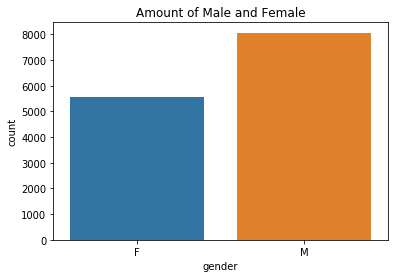

In [26]:
plot_gender = data.copy()
plot_gender = plot_gender.drop_duplicates(subset='person', keep="first")
gender_plot = plot_gender.filter(['gender'])
plt.title('Amount of Male and Female')
sns.countplot(x="gender", data=gender_plot)

There are more men than women as customers in Starbucks, this is quite interesting, I would have thought the opposite, Sadly we do not have the location of the Starbucks for this data to anlyse deeper in that direction.

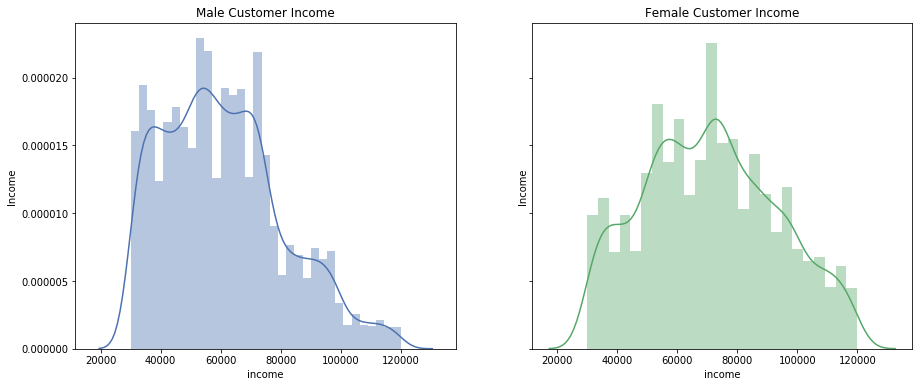

In [27]:
plot_dist = data.copy()
plot_dist = plot_dist.sort_values(by='amount', ascending=False).reset_index(drop=True)
#get unique users
plot_dist = plot_dist.drop_duplicates(subset='person', keep="first")

income_year = plot_dist.filter(['income', 'gender', 'start_year'])

income_female_year = income_year[income_year.gender == 'F']
income_male_year = income_year[income_year.gender == 'M']

sns.set_color_codes()

fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=2, sharex=True, sharey=True)

plt.sca(ax[0])
plt.title('Male Customer Income')
plt.xlabel('Income')
plt.ylabel('Income')
sns.distplot(income_male_year['income'],color="b")

plt.sca(ax[1])
plt.title('Female Customer Income')
plt.xlabel('Income')
plt.ylabel('Income')
sns.distplot(income_female_year['income'], color="g")

Sadly there is not geographical data available but based on the distributions female customers have higher income in this dataset than men. Purchasing power for women in this dataset is higher. I am very positive about this results.

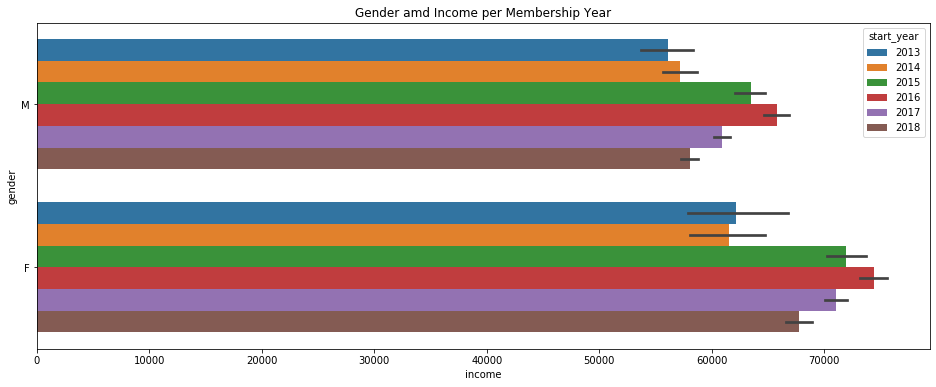

In [28]:
# Get unique users
plot_one = data.copy()
plot_one = plot_one.sort_values(by='amount', ascending=False).reset_index(drop=True)
plot_one = plot_one.drop_duplicates(subset='person', keep="first")

plt.figure(figsize=(16, 6))
plt.title('Gender amd Income per Membership Year')
sns.barplot(x="income", y="gender", hue= 'start_year', data=plot_one)

It also shows that the salaries for both groups reached a peak in 2016 and it still confirms, that female has higher salaries than men in this region. (I really went to the original dataset to check if I was not encoding incorrectly the values, it seems valid. I feel personally happy for this but very curious which Starbucks and cities are involved in this dataset )

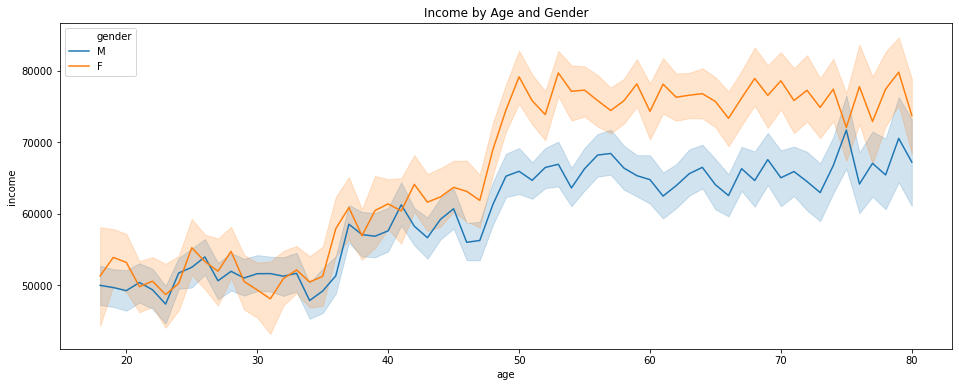

In [29]:
# Getting unique users
plot_two = data.copy()
plot_two = plot_two.sort_values(by='amount', ascending=False).reset_index(drop=True)
plot_two = plot_two.drop_duplicates(subset='person', keep="first")

inc_gen_age = plot_two.filter(['income', 'gender', 'age'])

plt.figure(figsize=(16, 6))
plt.title('Income by Age and Gender')
sns.lineplot(x="age", y="income", hue="gender", data=inc_gen_age)

The trend positions women with higher income than men, across different age values. The gap between both groups becomes relevand around 50 years, where women drastically report more income. This fully confirms that **old women** have more purchasing power and they are good candidates to design perhaps special offers for this group.

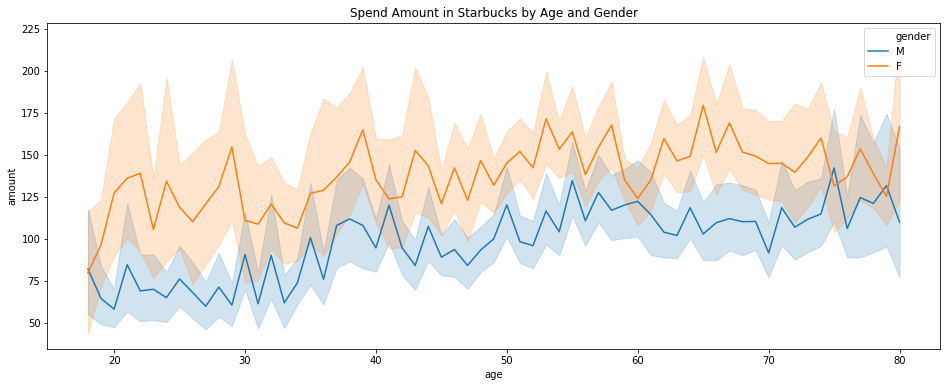

In [30]:
# Getting unique users
plot_spend = data.copy()
plot_spend = plot_spend.sort_values(by='amount', ascending=False).reset_index(drop=True)
plot_spend = plot_spend.drop_duplicates(subset='person', keep="first")

plot_spend = plot_spend.filter(['amount', 'gender', 'age'])

plt.figure(figsize=(16, 6))
plt.title('Spend Amount in Starbucks by Age and Gender')
sns.lineplot(x="age", y="amount", hue="gender", data=plot_spend)

It is becoming clear that women are big spenders, even if there are more men buying as we saw in a previous plot, women tend to spend more money on Starbucks

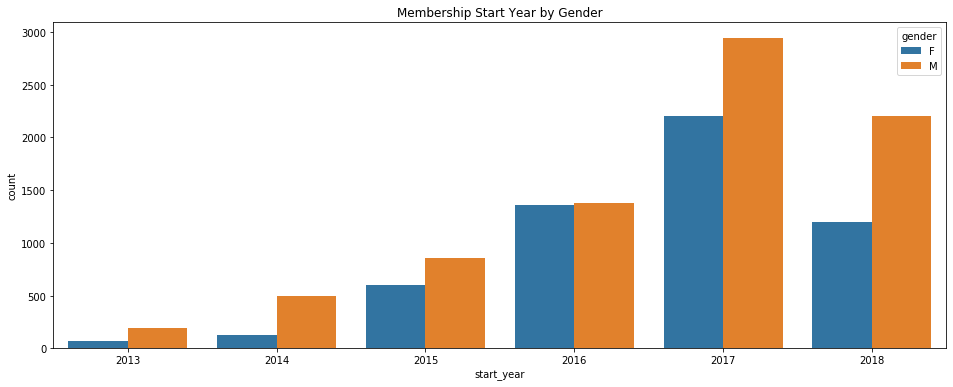

In [31]:
plot_gender = data.copy()
plot_gender = plot_gender.drop_duplicates(subset='person', keep="first")
gender_plot = plot_gender.filter(['gender', 'start_year'])

plt.figure(figsize=(16, 6))
plt.title('Membership Start Year by Gender')
sns.countplot(x="start_year", hue='gender' ,data=gender_plot)

Here we can see the membership subscription program having a great onboarding success, this confirms that a membership is valuable for Starbuck customers. Amazingly men are more involved into the memberships than women. Perhaps men consume more often and are more driven by discounts and women just buy more regardless discounts or benefits of membership programs.

Now let's take a dive into the statistics related to the offers and see potential trends.

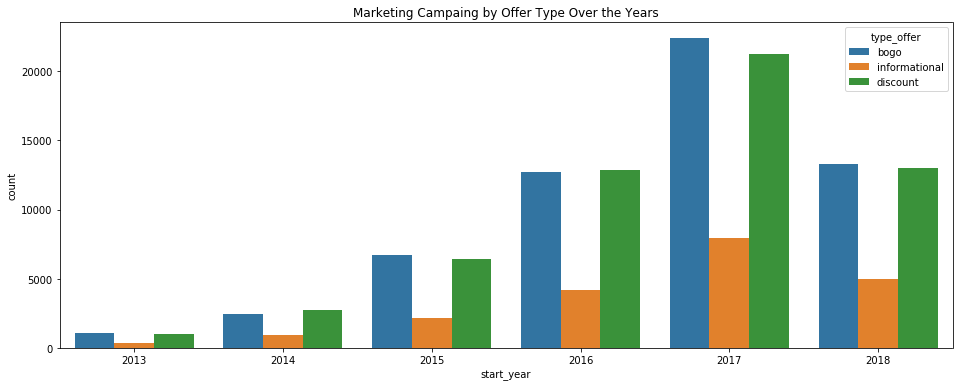

In [32]:
data_offers = data.copy()
offers_data = data_offers.filter(['gender', 'start_year', 'type_offer', 'event', 'offer_id', 'reward', 'difficulty','duration', 'income', 'amount', 'age'])

plt.figure(figsize=(16, 6))
plt.title('Marketing Campaing by Offer Type Over the Years')
sns.countplot(x="start_year", hue='type_offer' ,data=offers_data)


It seems that the offers are mostly based on discounts and BOGO and less informational offers. Now lets observe the rate of difficulty

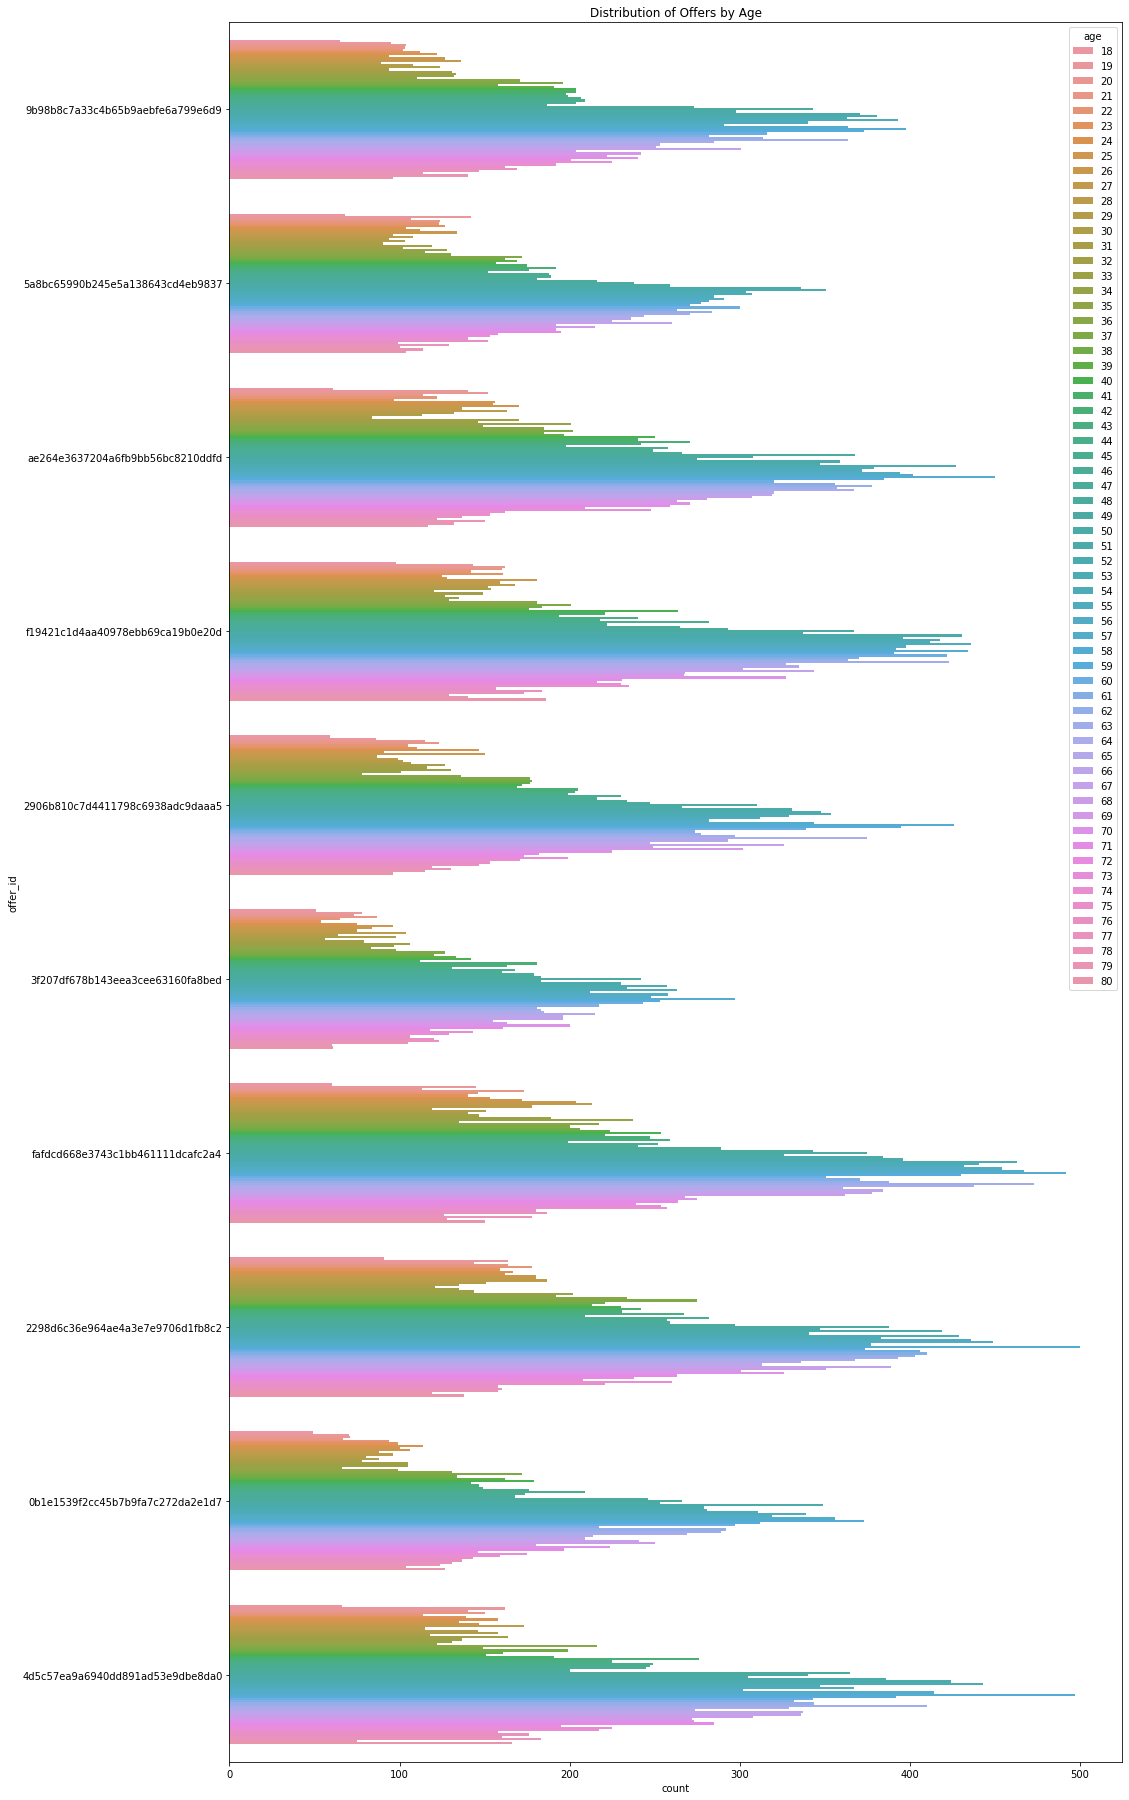

In [33]:
plt.figure(figsize=(16, 32))
plt.title('Distribution of Offers by Age')
sns.countplot(y="offer_id",hue="age", data=offers_data)

**Bsed on this partial heatmap we can see that the target customers for most of the offers are the users between 38-60 years old, which have most of the high income and expenses habits**

**Now we turn the page to analyse the response of the type of offers and how they impact the customers.**

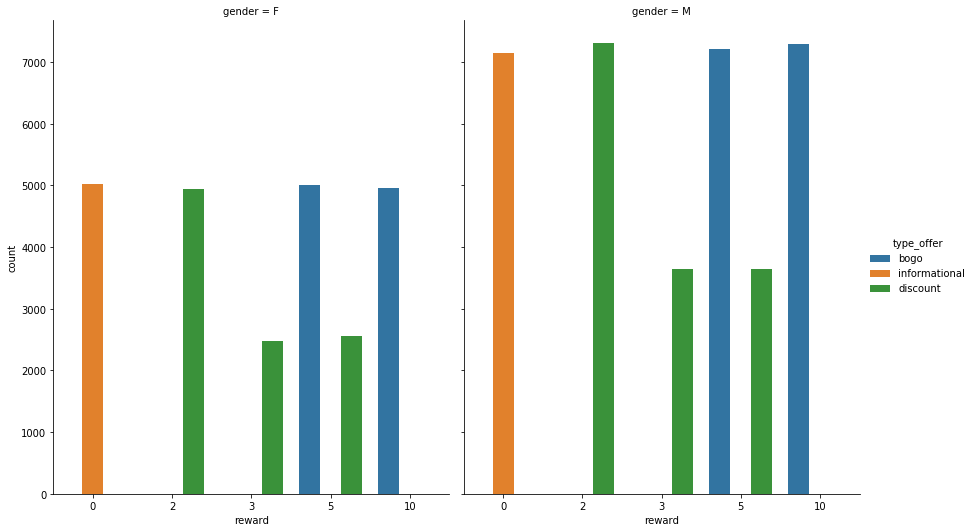

In [34]:
offers_data_event_received = offers_data[offers_data.event=='offer received'].reset_index(drop=True)
sns.catplot(x="reward", hue="type_offer", col="gender",
                data=offers_data_event_received, kind="count",
                height=7.5, aspect=.8, orient="h");

**Male receive much more offers than women, despite women spend more money on Starbucks, this may justify that they are more men customers.


**For analysis reasons and being in favour of more metrics indicating revenue for Starbucks. I hide on purpose the informational offers, which do not bring any value for the moment and compare between BOGO and Discount for male and female**

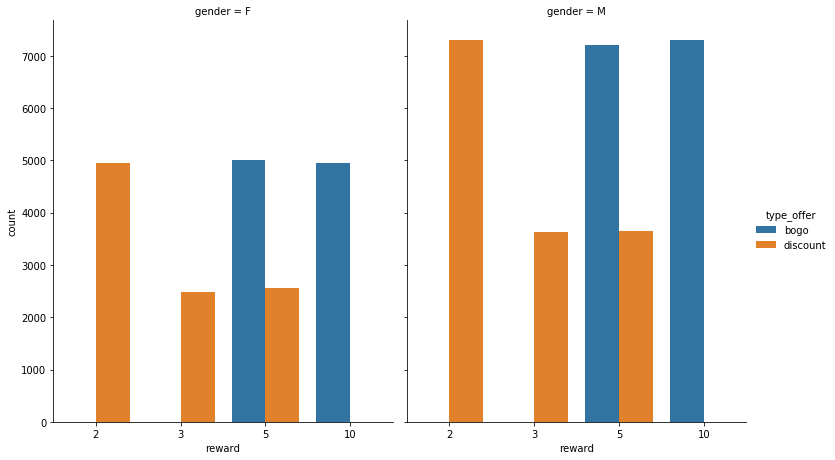

In [35]:
# Received
offers_data_event_received = offers_data[(offers_data.event=='offer received') & (offers_data.type_offer !='informational')].reset_index(drop=True)
sns.catplot(x="reward", hue="type_offer", col="gender",
                data=offers_data_event_received, kind="count",
                height=6.5, aspect=.8, orient="h");

**These are the received offers and men obviously receive more promotions than women.**

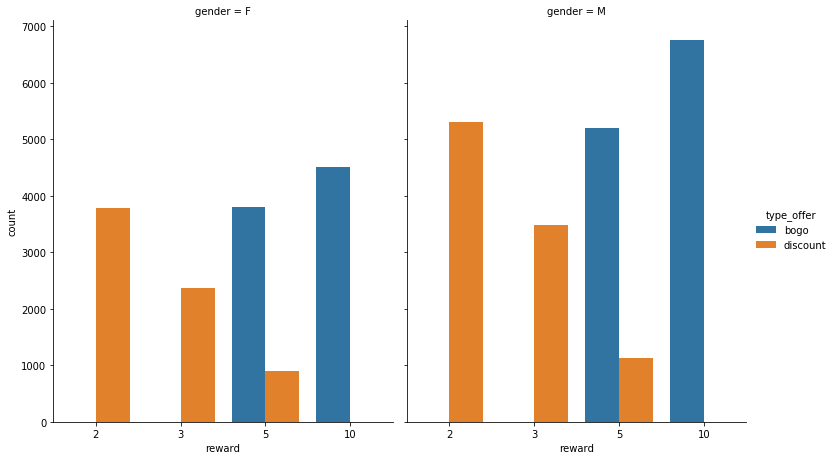

In [36]:
# Viewed
offers_data_event_viewed = offers_data[(offers_data.event=='offer viewed') & (offers_data.type_offer !='informational')].reset_index(drop=True)
sns.catplot(x="reward", hue="type_offer", col="gender",
                data=offers_data_event_viewed, kind="count",
                height=6.5, aspect=.8, orient="h");


**In the same trend men tend to view more the offers received than women**

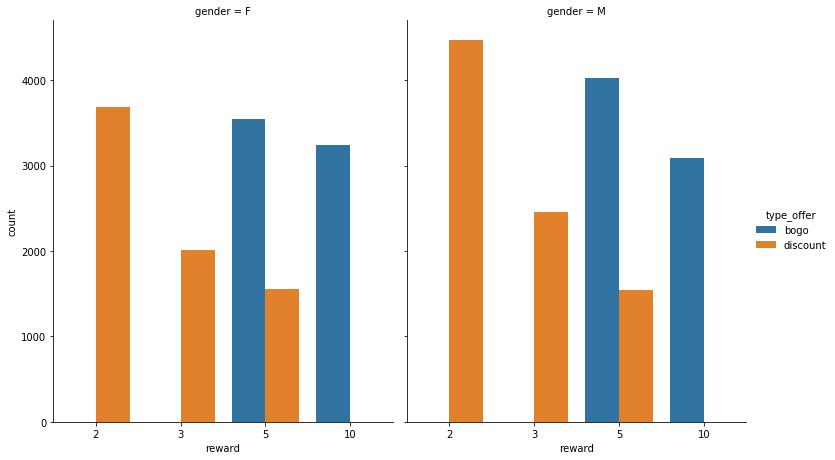

In [37]:
# Completed
offers_data_event_completed = offers_data[offers_data.event=='offer completed'].reset_index(drop=True)
sns.catplot(x="reward", hue="type_offer", col="gender",
                data=offers_data_event_completed, kind="count",
                height=6.5, aspect=.8, orient="h");

**In terms of completed offers, it seems that the offers are completed by male and females and the gap is not big specially for reward 5 and 10. I started to consider that there are offers by age but there are not differences between men and women** 

### Data Analysis Results

By exploring the data, we have discovered some insights, which I will enumerate by points:

* There are more males than females as customers during the capture of the datasets
* Women eran more than men in average and spend more money on Starbucks
* Salaries between women and men become significant different after the age of 45
* The offers from Starbucks target mostly customers between 38-60 years old.
* Membership grow between man and women tends to grow every year. However, men in 2017 and 2018 are dominant.
* Currently men receive more offers or promotions than women.
* Men tend to view more the offers received than women.
* It seems that the offers are completed by male and females and the gap is not big specially for reward 5 and 10.
* Women spend more money than men, receive less offers because they view less offers.


Based on this analysis and facts, there is a clear trend of the features needed to be able to consider, in order to predict a possible customer decision based on an offer.

#### FEATURES

The followinglist are the features that we have been preparing since the beggining of the file, I consider to the following ones, which we have seen an influence during the data analysis and exploration.

* person - not considered
* event  - not considered
* time_x  - not considered
* time_days_x  - not considered
* offer_received  - considered               
* offer_completed - considered               
* offer_viewed - considered                  
* offer_id   - not considered
* gender    - not considered
* age       - considered                     
* id_x      - not considered
* became_member_on  - not considered
* income - considered                        
* gender_map   - considered                  
* start_year   - considered                  
* start_month   - considered                 
* reward     - considered                    
* difficulty  - considered                   
* duration - considered                      
* id_y     - not considered
* 'email'   - considered
* 'mobile'   - considered
* 'social'  - considered
* 'web'     - considered                     
* type_offer - not considered
* offer_type_bogo                
* offer_type_discount            
* offer_type_informational       
* time_y   - not considered
* time_days_y - not considered
* amount - **considered but will drop NaN values**

In [38]:
matrix_plot = data.copy()
matrix_plot = matrix_plot.dropna(subset=['amount'])
features = matrix_plot.filter([ 'offer_received',
                                'offer_viewed',
                                'age',
                                'income',
                                'gender_map',
                                'start_month',
                                'reward',
                                'difficulty',
                                'duration',
                                'email',
                                'mobile',
                                'social',
                                'web',
                                'offer_type_bogo',
                                'offer_type_discount',
                                'offer_type_informational',
                                'amount'])

In [39]:
features

,offer_received,offer_viewed,age,income,gender_map,start_month,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,amount
0,1,0,75,100000.0,0,5,5,5,7,1,0,0,159.27
1,0,1,75,100000.0,0,5,5,5,7,1,0,0,159.27
2,0,0,75,100000.0,0,5,5,5,7,1,0,0,159.27
3,1,0,68,70000.0,1,4,5,5,7,1,0,0,57.73
4,0,1,68,70000.0,1,4,5,5,7,1,0,0,57.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136650,0,1,48,58000.0,1,6,10,10,5,1,0,0,4.62
136651,1,0,44,81000.0,0,3,10,10,5,1,0,0,165.98
136652,0,1,44,81000.0,0,3,10,10,5,1,0,0,165.98
136655,1,0,61,60000.0,0,7,10,10,5,1,0,0,37.09


### Prediction Model

In [40]:
y = matrix_plot['offer_completed']
X = features

# Create the test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=43)

lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape, y.index.shape

((94024, 13), (40297, 13), (94024,), (40297,), (134321, 13), (134321,))

### Evaluation

In [42]:
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

#traing score
print('Train Score:', float(train_score))

#test score
print('Test Score', float(test_score))

Train Score: 1.0
Test Score 1.0


In [43]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
10,offer_type_discount,-4.564753e+01,4.564753e+01
11,offer_type_informational,-4.564753e+01,4.564753e+01
9,offer_type_bogo,-4.564753e+01,4.564753e+01
1,offer_viewed,-1.000000e+00,1.000000e+00
0,offer_received,-1.000000e+00,1.000000e+00
8,duration,7.924279e-15,7.924279e-15
6,reward,4.439075e-15,4.439075e-15
7,difficulty,-2.907148e-15,2.907148e-15
4,gender_map,-2.107884e-15,2.107884e-15
5,start_month,-5.476331e-16,5.476331e-16


### CONCLUSION

During the data exploration, we discovered several facts and elements which helped to the discovery of the important features that influence the impact of an offer or not. Some of the facts discovered are: 

* There are more males than females as customers during the capture of the datasets
* Women eran more than men in average and spend more money on Starbucks
* Salaries between women and men become significant different after the age of 45
* The offers from Starbucks target mostly customers between 38-60 years old.
* Membership grow between man and women tends to grow every year. However, men in 2017 and 2018 are dominant.
* Currently men receive more offers or promotions than women.
* Men tend to view more the offers received than women.
* It seems that the offers are completed by male and females and the gap is not big specially for reward 5 and 10.
* Women spend more money than men, receive less offers because they view less offers.

In addition the features were selected in order to make a simple linearRegression Model. It sadly reported to be marking overfitting with a perfect prediction, which is far for ideal I consider that something wrong happened in the computation.

Finally, what I wanted to emphazise about the features is that Linera regression provide us the top features that influence the decision of sending one offer from another. We can see from the last table that **offer_type** is the main category to predict the offer and the algorithm also says that income is the less important feature.

### Recommendations

My advices, regardless the model to predict offers are:


* Men are already taking advantage of the offers and they are passive customers who continously show off for buying Starbucks products, the strategy here should continue to offer even more aggresive discounts by combining rewards and dificculty. Men tent to go for the higher reward.

* Women have a high potential to increase the revenue, they spend more than men in Starbucks products. It would be interesting to create only products for them and make specific offers for women. For the moment the BOGO offer is applied to men and women. However, if we can make something more personalize for women then that would be the direction to go.

* Women have very interesting and predictable consumer behaviour based on different studies and it would be intesresting to sell an experience to women insted to have only BOGO.

* The missing part of the dataset in order to make more accurate insigths was the location data of the people who filled the memberships.

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

0